In [174]:
# !pip install -U gensim~=3.2.0
import gensim
import gzip
import numpy as np
import os
import pandas as pd
# !pip install --upgrade-strategy=only-if-needed tensorflow~=1.6.0rc0
import tensorflow as tf

In [175]:
local_dir_name = 'data'
WORD2VEC_FILE = os.path.join(local_dir_name+"/embeddings", "GoogleNews-vectors-negative300.bin.gz")
ANALOGIES_FILE = os.path.join(local_dir_name, "questions-words.txt")

In [176]:
def load_word2vec_format(f, max_num_words=None):
  """Loads word2vec data from a file handle.

  Similar to gensim.models.keyedvectors.KeyedVectors.load_word2vec_format
  but takes a file handle as input rather than a filename. This lets us use
  GFile. Also only accepts binary files.

  Args:
    f: file handle
    max_num_words: number of words to load. If None, load all.

  Returns:
    Word2vec data as keyedvectors.EuclideanKeyedVectors.
  """
  header = f.readline()
  vocab_size, vector_size = (
      int(x) for x in header.rstrip().split())  # throws for invalid file format
  print "vector_size =  %d" % vector_size
  result = gensim.models.keyedvectors.EuclideanKeyedVectors()
  num_words = 0
  result.vector_size = vector_size
  result.syn0 = np.zeros((vocab_size, vector_size), dtype=np.float32)
  
  def add_word(word, weights):
    word_id = len(result.vocab)
    if word in result.vocab:
      print("duplicate word '%s', ignoring all but first", word)
      return
    result.vocab[word] = gensim.models.keyedvectors.Vocab(
        index=word_id, count=vocab_size - word_id)
    result.syn0[word_id] = weights
    result.index2word.append(word)

  if max_num_words and max_num_words < vocab_size:
    num_embeddings = max_num_words
  else:
    num_embeddings = vocab_size
  print "Loading %d embeddings" % num_embeddings
  
  binary_len = np.dtype(np.float32).itemsize * vector_size
  for _ in xrange(vocab_size):
    # mixed text and binary: read text first, then binary
    word = []
    while True:
      ch = f.read(1)
      if ch == b' ':
        break
      if ch == b'':
        raise EOFError("unexpected end of input; is count incorrect or file otherwise damaged?")
      if ch != b'\n':  # ignore newlines in front of words (some binary files have)
        word.append(ch)
    word = gensim.utils.to_unicode(b''.join(word), encoding='utf-8', errors='strict')
    weights = np.frombuffer(f.read(binary_len), dtype=np.float32)
    add_word(word, weights)
    num_words = num_words + 1
    if max_num_words and num_words == max_num_words:
      break
  if result.syn0.shape[0] != len(result.vocab):
    print(
        "duplicate words detected, shrinking matrix size from %i to %i",
        result.syn0.shape[0], len(result.vocab))
  result.syn0 = np.ascontiguousarray(result.syn0[:len(result.vocab)])
  assert (len(result.vocab), vector_size) == result.syn0.shape

  print("loaded %s matrix", result.syn0.shape)
  return result

In [177]:
%%time
if not 'client' in vars():
  print "Loading word embeddings from %s" % WORD2VEC_FILE
  with gzip.GzipFile(fileobj=open(WORD2VEC_FILE, 'r')) as f:
    client = load_word2vec_format(f, max_num_words=2000000)

CPU times: user 9 µs, sys: 4 µs, total: 13 µs
Wall time: 24.1 µs


In [178]:
def print_knn(client, v, k):
  print "%d closest neighbors to A-B+C:" % k
  for neighbor, score in client.similar_by_vector(
      v.flatten().astype(float), topn=k):
    print "%s : score=%f" % (neighbor, score)

In [179]:
# Use a word embedding to compute an analogy
# Edit the parameters below to get different analogies
A = "asian"
B = "american"
C = "smart"
NUM_ANALOGIES = 5

in_arr = []
for i, word in enumerate((A, B, C)):
  in_arr.append(client.word_vec(word))
in_arr = np.array([in_arr])

print_knn(client, -in_arr[0, 0, :] + in_arr[0, 1, :] + in_arr[0, 2, :],
          NUM_ANALOGIES)

5 closest neighbors to A-B+C:
smart : score=0.668151
intelligent : score=0.454270
dumb : score=0.442581
smarter : score=0.412079
american : score=0.410000


In [180]:
def load_analogies(filename):
  """Loads analogies.

  Args:
    filename: the file containing the analogies.

  Returns:
    A list containing the analogies.
  """
  analogies = []
  with open(filename, "r") as fast_file:
    for line in fast_file:
      line = line.strip()
      # in the analogy file, comments start with :
      if line[0] == ":":
        continue
      words = line.split()
      # there are no misformatted lines in the analogy file, so this should
      # only happen once we're done reading all analogies.
      if len(words) != 4:
        print "Invalid line: %s" % line
        continue
      analogies.append(words)
  print "loaded %d analogies" % len(analogies)
  return analogies

In [181]:
analogies = load_analogies(ANALOGIES_FILE)
print "\n".join("%s is to %s as %s is to %s" % tuple(x) for x in analogies[-20:])

loaded 19544 analogies
write is to writes as increase is to increases
write is to writes as listen is to listens
write is to writes as play is to plays
write is to writes as predict is to predicts
write is to writes as provide is to provides
write is to writes as say is to says
write is to writes as scream is to screams
write is to writes as search is to searches
write is to writes as see is to sees
write is to writes as shuffle is to shuffles
write is to writes as sing is to sings
write is to writes as sit is to sits
write is to writes as slow is to slows
write is to writes as speak is to speaks
write is to writes as swim is to swims
write is to writes as talk is to talks
write is to writes as think is to thinks
write is to writes as vanish is to vanishes
write is to writes as walk is to walks
write is to writes as work is to works


In [182]:
def _np_normalize(v):
  """Returns the input vector, normalized."""
  return v / np.linalg.norm(v)


def load_vectors(client, analogies):
  """Loads and returns analogies and embeddings.

  Args:
    client: the client to query.
    analogies: a list of analogies.

  Returns:
    A tuple with:
    - the embedding matrix itself
    - a dictionary mapping from strings to their corresponding indices
      in the embedding matrix
    - the list of words, in the order they are found in the embedding matrix
  """
  words_unfiltered = set()
  for analogy in analogies:
    words_unfiltered.update(analogy)
  print "found %d unique words" % len(words_unfiltered)

  vecs = []
  words = []
  index_map = {}
  for word in words_unfiltered:
    try:
      vecs.append(_np_normalize(client.word_vec(word)))
      index_map[word] = len(words)
      words.append(word)
    except KeyError:
      print "word not found: %s" % word
  print "words not filtered out: %d" % len(words)

  return np.array(vecs), index_map, words

In [183]:
embed, indices, words = load_vectors(client, analogies)

embed_dim = len(embed[0].flatten())
print "word embedding dimension: %d" % embed_dim

found 905 unique words
words not filtered out: 905
word embedding dimension: 300


In [184]:
np.shape(embed)

(905, 300)

In [185]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [186]:
embeddings = client

In [187]:
from matplotlib import pyplot as plt

In [188]:
from sklearn.model_selection import train_test_split


In [189]:
pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
train_vectors, test_vectors, train_targets, test_targets = train_test_split(vectors, targets, test_size=0.1, random_state=0)

In [190]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='auto').fit(train_vectors,train_targets)
clf.score(test_vectors,test_targets)


0.946031746031746

<BarContainer object of 100 artists>

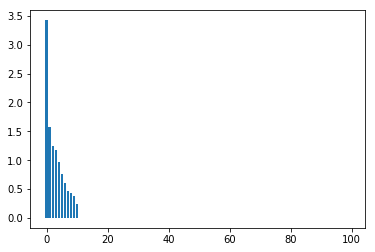

In [191]:
import nltk 
from nltk.corpus import wordnet 
good = []
bad=  []

for word in pos_words:
    a = wordnet.synsets(word)
    if len(a)>0:
        syn = a[0] .lemmas()[0]
        if len(syn.antonyms())>0:
            good.append(word)
            bad.append(syn.antonyms()[0].name()) 
            
good_vectors=[]
bad_vectors = []
good = ['good','beautiful','happy','positive','compentent','smart','interesting','pleasant','best','honest','wealthy','wonderful']
bad = ['bad','ugly','sad','negative','incompetent','dumb','boring','horrible','worst','corrupt','poor','awful']
# good = ['amazing']
# bad = ['horrible']
choices = np.random.choice(len(good),20)
for i,j in zip(good,bad):
    if i in embeddings and j in embeddings:
        good_vectors.append(_np_normalize(embeddings[i]))
        bad_vectors.append(_np_normalize(embeddings[j]))

good_vectors = np.array(good_vectors)
bad_vectors = np.array(bad_vectors)
X = good_vectors-bad_vectors
m = np.dot(X.T,X)
evals, evecs = np.linalg.eig(m)
vec = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.bar(np.arange(100),evals[:100])

<BarContainer object of 100 artists>

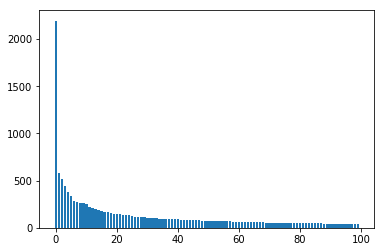

In [192]:
m=np.dot(pos_vectors.T,pos_vectors)
evals, evecs = np.linalg.eig(m)
vec_pos = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.figure()
plt.bar(np.arange(100),evals[:100])

In [193]:
neg_vectors=neg_vectors[np.random.choice(len(pos_vectors),len(pos_vectors))]

<BarContainer object of 100 artists>

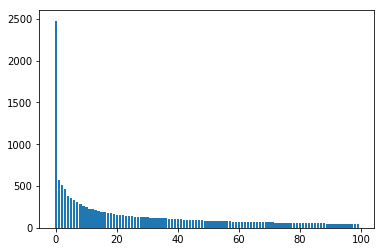

In [194]:
m=np.dot(neg_vectors.T,neg_vectors)
evals, evecs = np.linalg.eig(m)
vec_neg = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.figure()
plt.bar(np.arange(100),evals[:100])

In [195]:
vec=vec_pos-vec_neg

In [196]:
WORD = "bad"
word_vec = _np_normalize(client.word_vec(WORD))
print vec.dot(word_vec.T)

-0.19332166


In [197]:
count = 0 
for i,j in zip(vectors,(targets*2-1)*-1):
    if int(np.sign(i.dot(vec))) == j:
        count+=1
print count/float(len(targets))

0.919987299571


In [198]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
#     'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
#     'Diasporic',
    'Sikh',
#     'Juche',
    'Jewish',
#     'Bahai',
#     'Jains',
#     'Shinto',
#     'Pagan'
]
gender= ["male","female","her","him","man","woman","boy","girl","his","hers","mom","dad"]#perhaps try all terms intraprotected group

In [199]:
words = filter(lambda x: x.lower() in embeddings,religions)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: embeddings[w.lower()].dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df

         word  sentiment_score
3     Islamic        -0.584785
0     Zionist        -0.567522
6       Hindu        -0.545433
9      Jewish        -0.480932
5     Atheist        -0.397396
2   Christian        -0.314847
4  Protestant        -0.203938
8        Sikh        -0.167086
1    Catholic        -0.096627
7    Buddhist         0.051181


Let's now look at the words with the largest *negative* projection onto the gender dimension.

In [200]:
words = set()
for a in analogies:
  words.update(a)

df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: client.word_vec(w).dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df.head(10)


              word  sentiment_score
743      dishonest        -0.798603
579  irresponsible        -0.795579
217     irrational        -0.749026
428     uninformed        -0.728570
508      unethical        -0.708107
503   unacceptable        -0.650462
304   unproductive        -0.637240
83       illogical        -0.627010
31           worse        -0.619092
380    inefficient        -0.580581


Let's now look at the words with the largest *positive* projection onto the gender dimension.

In [201]:
df.sort_values(by="sentiment_score", inplace=True, ascending=False)
print df.head(10)

           word  sentiment_score
370    sweetest         0.782153
206     amazing         0.781372
43   impressive         0.762609
14     tastiest         0.690337
371    tasteful         0.679125
115       great         0.664849
863       tasty         0.653306
328    pleasant         0.635674
283   fortunate         0.581029
711      widest         0.572260


In [202]:
tf.reset_default_graph()
def tf_normalize(x):
  """Returns the input vector, normalized.

  A small number is added to the norm so that this function does not break when
  dealing with the zero vector (e.g. if the weights are zero-initialized).

  Args:
    x: the tensor to normalize
  """
  return x / (tf.norm(x) + np.finfo(np.float32).tiny)


class AdversarialEmbeddingModel(object):
  """A model for doing adversarial training of embedding models."""

  def __init__(self, client,
               data_p, embed_dim, projection,
               projection_dims, pred,X,Y,X_test,Y_test):
    """Creates a new AdversarialEmbeddingModel.

    Args:
      client: The (possibly biased) embeddings.
      data_p: Placeholder for the data.
      embed_dim: Number of dimensions used in the embeddings.
      projection: The space onto which we are "projecting".
      projection_dims: Number of dimensions of the projection.
      pred: Prediction layer.
    """
    # load the analogy vectors as well as the embeddings
    self.client = client
    self.data_p = data_p
    self.embed_dim = embed_dim
    self.projection = projection
    self.projection_dims = projection_dims
    self.pred = pred
    self.X=X
    self.Y=Y
    self.X_test = X_test
    self.Y_test = Y_test

  def nearest_neighbors(self, sess, in_arr,
                        k):
    """Finds the nearest neighbors to a vector.

    Args:
      sess: Session to use.
      in_arr: Vector to find nearest neighbors to.
      k: Number of nearest neighbors to return
    Returns:
      List of up to k pairs of (word, score).
    """
    v = sess.run(self.pred, feed_dict={self.data_p: in_arr})
    return self.client.similar_by_vector(v.flatten().astype(float), topn=k)

  def write_to_file(self, sess, f):
    """Writes a model to disk."""
    np.savetxt(f, sess.run(self.projection))

  def read_from_file(self, sess, f):
    """Reads a model from disk."""
    loaded_projection = np.loadtxt(f).reshape(
        [self.embed_dim, self.projection_dims])
    sess.run(self.projection.assign(loaded_projection))

    
  def fit(self,
          sess,
          data,
          data_p,
          labels,
          labels_p,
          protect,
          protect_p,
          gender_direction,
          pred_learning_rate,
          protect_learning_rate,
          protect_loss_weight,
          num_steps,
          batch_size,
          debug_interval=1000):
    """Trains a model.

    Args:
      sess: Session.
      data: Features for the training data.
      data_p: Placeholder for the features for the training data.
      labels: Labels for the training data.
      labels_p: Placeholder for the labels for the training data.
      protect: Protected variables.
      protect_p: Placeholder for the protected variables.
      gender_direction: The vector from find_gender_direction().
      pred_learning_rate: Learning rate for predicting labels.
      protect_learning_rate: Learning rate for protecting variables.
      protect_loss_weight: The constant 'alpha' found in
          debias_word_embeddings.ipynb.
      num_steps: Number of training steps.
      batch_size: Number of training examples in each step.
      debug_interval: Frequency at which to log performance metrics during
          training.
    """
  
    ##########################
    feed_dict = {
        data_p: data,
        labels_p: labels,
        protect_p: protect    }
    
    # define the prediction loss
    pred_loss = tf.losses.mean_squared_error(labels_p, self.pred)
#     pred_loss = tf.losses.absolute_difference(labels_p, self.pred)

    # compute the prediction of the protected variable.
    # The "trainable"/"not trainable" designations are for the predictor. The
    # adversary explicitly specifies its own list of weights to train.
    protect_weights = tf.get_variable(
        "protect_weights", [self.embed_dim, 1], trainable=False)
    
    protect_pred = tf.matmul(self.pred, protect_weights)#changr
    protect_loss = tf.losses.mean_squared_error(protect_p, protect_pred)

    pred_opt = tf.train.AdamOptimizer(pred_learning_rate)
    protect_opt = tf.train.AdamOptimizer(protect_learning_rate)

    protect_grad = {v: g for (g, v) in pred_opt.compute_gradients(protect_loss)}
    pred_grad = []

    # applies the gradient expression found in the document linked
    # at the top of this file.
    for (g, v) in pred_opt.compute_gradients(pred_loss):
      unit_protect = tf_normalize(protect_grad[v])
      # the two lines below can be commented out to train without debiasing
      g -= tf.reduce_sum(g * unit_protect) * unit_protect
      g -= protect_loss_weight * protect_grad[v]
      pred_grad.append((g, v))
      pred_min = pred_opt.apply_gradients(pred_grad)

    # compute the loss of the protected variable prediction.
    protect_min = protect_opt.minimize(protect_loss, var_list=[protect_weights])
  # Parameters

    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    ###############################################################################
    step = 0
    while step < num_steps:
      # pick samples at random without replacement as a minibatch
      ids = np.random.choice(len(data), batch_size, False)
      data_s, labels_s, protect_s = data[ids], labels[ids], protect[ids]
      sgd_feed_dict = {
          data_p: data_s,
          labels_p: labels_s,
          protect_p: protect_s,
      }

#       if not step % debug_interval:
#         metrics = [pred_loss, protect_loss, self.projection]
#         metrics_o = sess.run(metrics, feed_dict=feed_dict)
#         pred_loss_o, protect_loss_o, proj_o = metrics_o
#         log stats every so often: number of steps that have passed,
#         prediction loss, adversary loss
#         print("step: %d; pred_loss_o: %f; protect_loss_o: %f" % (step,
#                      pred_loss_o, protect_loss_o))
#         for i in range(proj_o.shape[1]):
#           print("proj_o: %f; dot(proj_o, gender_direction): %f)" %
#                        (np.linalg.norm(proj_o[:, i]),
#                        np.dot(proj_o[:, i].flatten(), gender_direction)))
      sess.run([pred_min, protect_min], feed_dict=sgd_feed_dict)
      step += 1
      
def filter_analogies(analogies,
                     index_map):
  filtered_analogies = []
  for analogy in analogies:
    if filter(index_map.has_key, analogy) != analogy:
      print "at least one word missing for analogy: %s" % analogy
    else:
      filtered_analogies.append(map(index_map.get, analogy))
  return filtered_analogies

def make_data(
    analogies, embed,
    gender_direction):
  """Preps the training data.

  Args:
    analogies: a list of analogies
    embed: the embedding matrix from load_vectors
    gender_direction: the gender direction from find_gender_direction

  Returns:
    Three numpy arrays corresponding respectively to the input, output, and
    protected variables.
  """
  data = []
  labels = []
  protect = []
  for analogy in analogies:
    # the input is just the word embeddings of the first three words
    data.append(embed[analogy[:3]])
    # the output is just the word embeddings of the last word
    labels.append(embed[analogy[3]])
    # the protected variable is the gender component of the output embedding.
    # the extra pair of [] is so that the array has the right shape after
    # it is converted to a numpy array.
    protect.append([np.dot(embed[analogy[3]], gender_direction)])
  # Convert all three to numpy arrays, and return them.
  return tuple(map(np.array, (data, labels, protect)))

Edit the training parameters below to experiment with different training runs.

For example, try increasing the number of training steps to 50k.

In [203]:
analogy_indices = filter_analogies(analogies, indices)

data, labels, protect = make_data(analogy_indices, embed, vec)
np.shape(data),np.shape(labels),np.shape(protect)

((19544, 3, 300), (19544, 300), (19544, 1))

In [204]:
labels  = embeddings.syn0norm

In [205]:
%%time
protect=[]
for i in labels:
    protect.append(i.dot(vec))

CPU times: user 1.33 s, sys: 22.7 ms, total: 1.36 s
Wall time: 1.36 s


In [206]:
len(protect)

2000000

In [130]:
w_h=[]

In [134]:
%%time
# Edit the training parameters below to experiment with different training runs.
# For example, try 
pred_learning_rate = 2**-16
protect_learning_rate = 2**-16
# protect_loss_weight = 0.5
num_steps = 100000
batch_size = 1000

embed_dim = 300
projection_dims = 1

Y = np.array([targets, -(targets-1)]).T  # The model currently needs one column for each class
X, X_test, Y, Y_test = train_test_split(vectors, Y)

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
with tf.variable_scope('var_scope', reuse=tf.AUTO_REUSE):
    weights = [.5,1,2,4,8,16]
    for i in weights:
        print "weights", i
        protect_loss_weight = i
        analogy_indices = filter_analogies(analogies, indices)

        data, labels, protect = make_data(analogy_indices, embed, vec)
        data_p = tf.placeholder(tf.float32, shape=[None, 3, embed_dim], name="data")
        labels_p = tf.placeholder(tf.float32, shape=[None, embed_dim], name="labels")
        protect_p = tf.placeholder(tf.float32, shape=[None, 1], name="protect")

        # projection is the space onto which we are "projecting". By default, this is
        # one-dimensional, but this can be tuned by projection_dims
        projection = tf.get_variable("projection", [embed_dim, projection_dims])

        # build the prediction layer
        # pred is the simple computation of d = -a + b + c for a : b :: c : d
        pred = labels_p #-data_p[:, 0, :] + data_p[:, 1, :] + data_p[:, 2, :]
        pred -= tf.matmul(tf.matmul(pred, projection), tf.transpose(projection))

        trained_model = AdversarialEmbeddingModel(
            client, data_p, embed_dim, projection, projection_dims, pred,X,Y,X_test,Y_test)
        trained_model.fit(sess, data, data_p, labels, labels_p, protect, protect_p, vec,
                  pred_learning_rate,
                protect_learning_rate, protect_loss_weight, num_steps, batch_size)
        w=None
        with sess.as_default(): w= trained_model.projection.eval()
        w_h.append(w)
        for j in [nationalities,religions]:
            print j[0]
            words = j
            a=map(lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec),words)
            print np.sum(np.array(a)**2)/len(a)

            a=map(lambda a: embeddings[a.lower()].dot(vec),words)
            print np.sum(np.array(a)**2)/len(a)
            
        print evaluate_word_pairs(model=embeddings,pairs="data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

weights 0.5
German
0.019218208268284798
0.04494735971093178
Zionist
0.027191519737243652
0.15805819034576415


NameError: name 'evaluate_word_pairs' is not defined

In [155]:
import pickle
 
with open('p.pkl', 'wb') as f:
    pickle.dump(w_h, f)

In [28]:
import pickle


In [207]:
w_h = []
with (open('p.pkl', "rb")) as openfile:
    while True:
        try:
            w_h.append(pickle.load(openfile))
        except EOFError:
            break

In [53]:
for i in w_h[0]:
    w=i
    for j in [nationalities,religions]:
                print j[0]
                words = j
                a=map(lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec),words)
                print np.sum(np.array(a)**2)/len(a)

                a=map(lambda a: embeddings[a.lower()].dot(vec),words)
                print np.sum(np.array(a)**2)/len(a)

#     print evaluate_word_pairs(model=embeddings,pairs="data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

German
0.014502015896141529
0.04494735971093178
Zionist
0.027266031503677367
0.15805819034576415
German
0.014468959532678127
0.04494735971093178
Zionist
0.023911136388778686
0.15805819034576415
German
0.011950654909014702
0.04494735971093178
Zionist
0.02506239116191864
0.15805819034576415
German
0.010397394187748432
0.04494735971093178
Zionist
0.024149271845817565
0.15805819034576415
German
0.007686716504395008
0.04494735971093178
Zionist
0.02003946006298065
0.15805819034576415
German
0.010644745081663132
0.04494735971093178
Zionist
0.02474125474691391
0.15805819034576415
German
0.008693964220583439
0.04494735971093178
Zionist
0.020556324720382692
0.15805819034576415


In [212]:
count=0
for i in sentences:
    if len(i.split(" "))<5 and len(i.split(" "))>1: count+=1

In [213]:
count

859

In [371]:
df = pd.read_csv("data/kaggle_toxicity/train.csv")
def generate_train_test_set(model,targets,sentences,limit=1000,dim=300):
    vectors = []
    labels = []
    count=0
    for i,sentence in enumerate(sentences):
        words = filter(lambda x: x in model,[x.lower() for x in sentence.split()])
        if len(words)<5 and len(words)>1:
            vectors.append(np.mean(model[words],axis = 0))
            labels.append(targets[i])
            count+=1
    print count, " sentences in embeddings, ", limit - count, " sentences not in embeddings"
    return train_test_split(np.array(vectors), np.array(labels), test_size=0.1, random_state=0)

toxic_sentences = df[df["toxic"]==1]["comment_text"]
num_toxic_samples = len(toxic_sentences)
non_toxic_sentences = df[df["toxic"]==0]["comment_text"].sample(num_toxic_samples)
sentences = pd.concat([toxic_sentences, non_toxic_sentences])
targets  = np.zeros(num_toxic_samples*2)
targets[num_toxic_samples:] = 1
train_vectors, test_vectors, train_targets, test_targets = generate_train_test_set(embeddings,targets,sentences,limit=num_toxic_samples*2 ,dim=300)

2560  sentences in embeddings,  28028  sentences not in embeddings


In [372]:
np.shape(train_vectors)

(2304, 300)

In [373]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=4, solver='lbfgs',
                         multi_class='multinomial',)
model.fit(train_vectors, train_targets)
preds = model.predict(test_vectors)
# accuracy
(preds == test_targets).mean()

0.86328125

In [374]:
model.predict_proba([embeddings["fuck"]])

array([[9.99999042e-01, 9.58244382e-07]])

(0.5, 0.95)

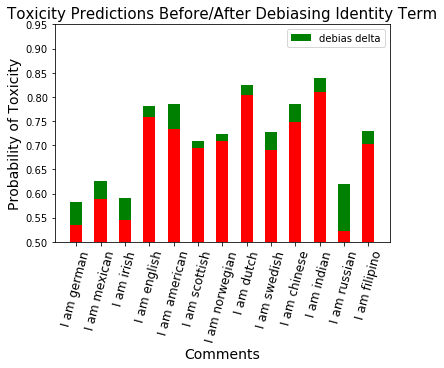

In [375]:
s=[]
for i in nationalities:
    if i.lower() not in ["italian","french","polish"]:
        s.append("I am " +i.lower())
p=[]
d=[]
for i in s:
    n=2
    a =i.split(" ")
    p.append(model.predict_proba([np.mean(embeddings[a],axis=0)])[0][0])
    de = embeddings[a]
    de[n,:] = embeddings[a[n]]-(np.dot(np.dot(w_h[0][4],w_h[0][4].T),embeddings[a[n]]))
    d.append((model.predict_proba([np.mean(de,axis=0)])[0][0]))

plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,p,width=.5,color='g',label="debias delta")
plt.xticks(index, s, fontsize=12, rotation=75)
plt.ylim(top=1,bottom=.3)

# plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before/After Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,d,width=.5,color='r')
plt.xticks(index, s, fontsize=12, rotation=75)
plt.legend(loc='upper middle')
plt.ylim(top=.95,bottom=.5)

(0, 1)

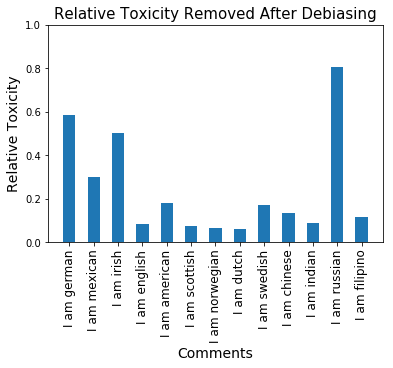

In [381]:
plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Relative Toxicity', fontsize=14)
plt.title("Relative Toxicity Removed After Debiasing",fontsize= 15)
index = np.arange(13)
delta = np.abs(p)-np.abs(d)
plt.bar(index,np.array(delta)/(np.array(p)-.5),width=.5)
# plt.bar(index,df["sentiment polarity"].values,width=.5)

# for i,j in enumerate(delta):
#     bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, s, fontsize=12, rotation=90)
plt.ylim(top=1,bottom=0)

In [379]:
print np.mean(np.array(delta)/(np.array(p)-.5))

0.2426930913357509


(0, 1)

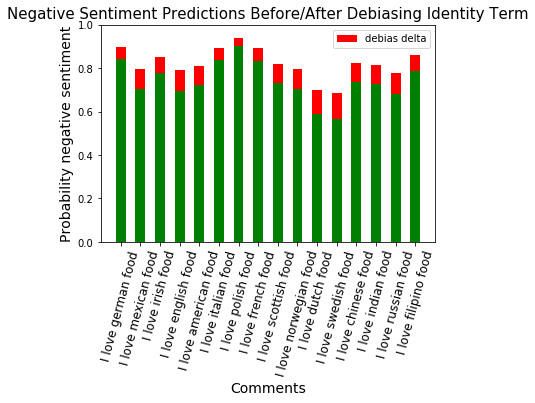

In [222]:
s=[]
for i in nationalities:
    s.append("I love " + i.lower() + " food")
p=[]
d=[]
for i in s:
    n=1
    a =i.split(" ")
    p.append(clf.predict_proba([np.mean(embeddings[a],axis=0)])[0][0])
    de = embeddings[a]
    de[n,:] = embeddings[a[n]]-(np.dot(np.dot(w_h[0][4],w_h[0][4].T),embeddings[a[n]]))
    d.append((clf.predict_proba([np.mean(de,axis=0)])[0][0]))

plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,p,width=.5,color='r',label="debias delta")
plt.xticks(index, s, fontsize=12, rotation=75)
plt.ylim(top=1,bottom=0)

# plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability negative sentiment', fontsize=14)
plt.title("Negative Sentiment Predictions Before/After Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,d,width=.5,color='g')
plt.xticks(index, s, fontsize=12, rotation=75)
plt.legend(loc='upper right')
plt.ylim(top=1,bottom=0)

### Analogy generation using the embeddings with bias reduced by the adversarial model

Let's see how the model that has been trained to mitigate bias performs on the analogy task.
As before, change "boss" to "friend" to see how those analogies have changed too.


In [135]:
table = {}
table1 = {}
for i in analogies:
    for j in i:
        if not j in table:
            table[j.lower()] = 1
            table1[j.lower()] = [i]
        else: 
            table1[j.lower()].append(i)
            table[j.lower()]+=1

In [136]:
for i in nationalities:
    if i.lower() in table1:
        print table1[i.lower()],i

[['Ukraine', 'Ukrainian', 'Germany', 'German']] German
[['Ukraine', 'Ukrainian', 'Mexico', 'Mexican']] Mexican
[['Ukraine', 'Ukrainian', 'Ireland', 'Irish']] Irish
[['Ukraine', 'Ukrainian', 'England', 'English']] English
[['Ukraine', 'Ukrainian', 'Italy', 'Italian']] Italian
[['Ukraine', 'Ukrainian', 'Poland', 'Polish']] Polish
[['Ukraine', 'Ukrainian', 'France', 'French']] French
[['Ukraine', 'Ukrainian', 'Norway', 'Norwegian']] Norwegian
[['Ukraine', 'Ukrainian', 'Netherlands', 'Dutch']] Dutch
[['Ukraine', 'Ukrainian', 'Sweden', 'Swedish']] Swedish
[['Ukraine', 'Ukrainian', 'China', 'Chinese']] Chinese
[['Ukraine', 'Ukrainian', 'India', 'Indian']] Indian
[['Ukraine', 'Ukrainian', 'Russia', 'Russian']] Russian


In [137]:
for i in nationalities:
    if i.lower() in table:
        print table[i.lower()],i

1 German
1 Mexican
1 Irish
1 English
1 Italian
1 Polish
1 French
1 Norwegian
1 Dutch
1 Swedish
1 Chinese
1 Indian
1 Russian


In [39]:
w=None
with sess.as_default():
    
#     w= trained_model.projection.eval()
    w= w_h[0]

In [40]:
client.similar_by_vector(embeddings['amazing'])

[(u'amazing', 1.0),
 (u'incredible', 0.9054001569747925),
 (u'awesome', 0.8282865285873413),
 (u'unbelievable', 0.8201264142990112),
 (u'fantastic', 0.7789870500564575),
 (u'phenomenal', 0.7642048001289368),
 (u'astounding', 0.7347068786621094),
 (u'wonderful', 0.7263180017471313),
 (u'unbelieveable', 0.716508150100708),
 (u'remarkable', 0.7095627188682556)]

In [41]:
client.similar_by_vector(embeddings['american'])

[(u'american', 0.9999999403953552),
 (u'america', 0.7169357538223267),
 (u'americans', 0.6877551078796387),
 (u'british', 0.6732469201087952),
 (u'indian', 0.659941554069519),
 (u'canadian', 0.6264656186103821),
 (u'chinese', 0.6219790577888489),
 (u'european', 0.6148862242698669),
 (u'mexican', 0.6054090261459351),
 (u'african', 0.603766679763794)]

In [42]:
client.similar_by_vector(embeddings['american']-np.dot(np.dot(w,w.T),embeddings['american']))

[(u'american', 0.9936076402664185),
 (u'america', 0.7085055112838745),
 (u'americans', 0.6694996356964111),
 (u'british', 0.6656462550163269),
 (u'indian', 0.6550458669662476),
 (u'canadian', 0.6233147382736206),
 (u'chinese', 0.6189991235733032),
 (u'european', 0.613082766532898),
 (u'mexican', 0.6051265001296997),
 (u'african', 0.5992313623428345)]

In [408]:
words= filter(lambda x: x.lower() in embeddings,nationalities)

0.044356927275657654


<Figure size 432x288 with 0 Axes>

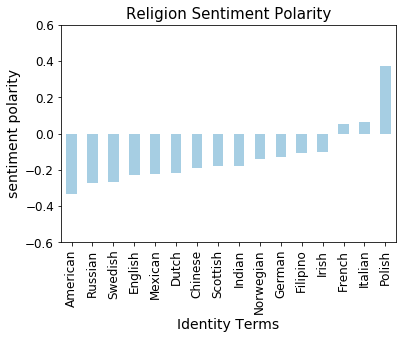

In [409]:
with sess.as_default():

    df1 = pd.DataFrame(data={"Identity Terms": list(words)})
    df1["sentiment polarity"] = df1["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
    df1.sort_values(by="sentiment polarity", inplace=True)
    plt.figure()
    df1.plot.bar(legend = False, ylim= (-.6,.6),x="Identity Terms",y="sentiment polarity",title= "Debiased Religion Sentiment Polarity",fontsize=12, colormap='Paired')
    plt.xlabel('Identity Terms', fontsize=14)
    plt.ylabel('sentiment polarity', fontsize=14)
    plt.title("Religion Sentiment Polarity",fontsize= 15)
a=map(lambda a: (embeddings[a.lower()]).dot(vec),words)
print np.sum(np.array(a)**2)/len(a)

In [410]:
words= df1["Identity Terms"].values

0.006929425057023764


<Figure size 432x288 with 0 Axes>

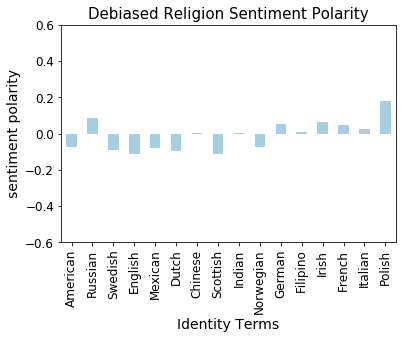

In [411]:
w= w_h[0][4]
with sess.as_default():

    df = pd.DataFrame(data={"Identity Terms": list(words)})
    df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
#     df.sort_values(by="sentiment polarity", inplace=True)
    plt.figure()
    df.plot.bar(legend = False, ylim= (-.6,.6),x="Identity Terms",y="sentiment polarity",title= "Debiased Religion Sentiment Polarity",fontsize=12, colormap='Paired')
    plt.xlabel('Identity Terms', fontsize=14)
    plt.ylabel('sentiment polarity', fontsize=14)
    plt.title("Debiased Religion Sentiment Polarity",fontsize= 15)
a=map(lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec),words)
print np.sum(np.array(a)**2)/len(a)

(-0.6, 0.6)

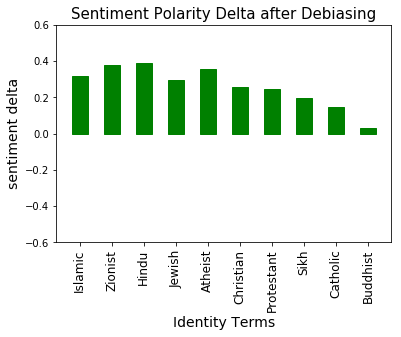

In [392]:
plt.figure()
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('sentiment delta', fontsize=14)
plt.title("Sentiment Polarity Delta after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = df["sentiment polarity"].values-df1["sentiment polarity"].values
bar = plt.bar(index,delta,width=.5)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=12, rotation=90)
plt.ylim(top=.6,bottom=-.6)

(0, 1)

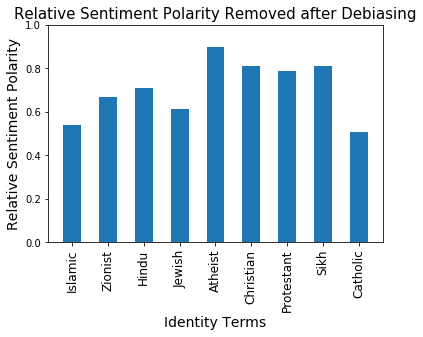

In [407]:
plt.figure()
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('Relative Sentiment Polarity', fontsize=14)
plt.title("Relative Sentiment Polarity Removed after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = np.abs(df1["sentiment polarity"].values)-np.abs(df["sentiment polarity"].values)
plt.bar(index,delta/np.abs(df1["sentiment polarity"].values),width=.5)
# plt.bar(index,df["sentiment polarity"].values,width=.5)
# for i,j in enumerate(delta):
#     bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=12, rotation=90)
plt.ylim(top=1,bottom=0)

In [280]:
import seaborn

In [ ]:
name_occurence.sort_values(ascending=True,by="toxicity")


In [281]:
male = ["male","him","man","boy","his","father","dad","men"]

In [282]:
female= ["female","her","woman","girl","hers","mother","mom","women"]

<IPython.core.display.Javascript object>


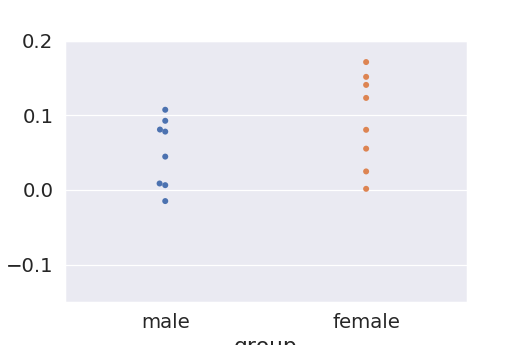

(-0.15, 0.2)

In [304]:
seaborn.set(font_scale=1.5)
frames = []
df = pd.DataFrame(data={"Identity Terms": list(male)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df['group'] = "male"
frames.append(df)
df_g = pd.DataFrame(data={"Identity Terms": list(female)})
df_g["sentiment polarity"] = df_g["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df_g['group'] = "female"
frames.append(df_g)

o = pd.concat(frames)
%matplotlib nbagg
plot = seaborn.swarmplot(x='group', y="sentiment polarity", data=o)
plot.set_ylim([-.15, .2])


<IPython.core.display.Javascript object>


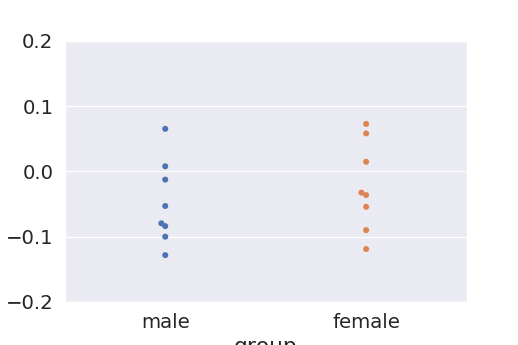

(-0.2, 0.2)

In [303]:
seaborn.set(font_scale=1.5)
frames = []
df = pd.DataFrame(data={"Identity Terms": list(male)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df['group'] = "male"
frames.append(df)
df_g = pd.DataFrame(data={"Identity Terms": list(female)})
df_g["sentiment polarity"] = df_g["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df_g['group'] = "female"
frames.append(df_g)

o = pd.concat(frames)
%matplotlib nbagg
plot = seaborn.swarmplot(x='group', y="sentiment polarity", data=o)
plot.set_ylim([-.2, .1])

0.20355020222002063
0.2775666800500944


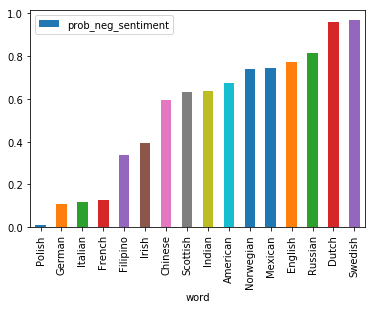

In [257]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda w: clf.predict_proba([embeddings[w.lower()]])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
print np.sum(np.abs(np.array(a)-.5))/len(a)
df.plot.bar(x="word",y="prob_neg_sentiment")


0.12045944783681067
0.2672947120552527


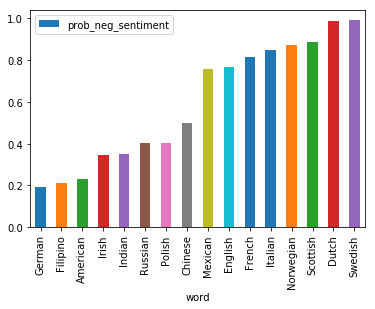

In [258]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda a: clf.predict_proba([(embeddings[a.lower()]-np.dot(np.dot(w,w.T),embeddings[a.lower()]))])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
print np.sum(np.abs(np.array(a)-.5))/len(a)

df.plot.bar(x="word",y="prob_neg_sentiment")

In [172]:
evaluate_word_pairs(model=embeddings,pairs="data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :x)

((0.6238773451304681, 1.7963247628700625e-39),
 SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45),
 0.0)

In [164]:
(X,y,l) = load_vectors(embeddings,analogies)
analogy_accuracy(X,l,embeddings,n = 1,samples=5000,model=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

0.002
0.004
0.006
0.008
0.01
0.012
0.014
0.016
0.018
0.02
0.022
0.024
0.026
0.028
0.03
0.032
0.034
0.036
0.038
0.04
0.042
0.044
0.046
0.048
0.05
0.052
0.054
0.056
0.058
0.06
0.062
0.064
0.066
0.068
0.07
0.072
0.074
0.076
0.078
0.08
0.082
0.084
0.086
0.088
0.09
0.092
0.094
0.096
0.098
0.1
0.102
0.104
0.106
0.108
0.11
0.112
0.114
0.116
0.118
0.12
0.122
0.124
0.126
0.128
0.13
0.132
0.134
0.136
0.138
0.14
0.142
0.144
0.146
0.148
0.15
0.152
0.154
0.156
0.158
0.16
0.162
0.164
0.166
0.168
0.17
0.172
0.174
0.176
0.178
0.18
0.182
0.184
0.186
0.188
0.19
0.192
0.194
0.196
0.198
0.2
0.202
0.204
0.206
0.208
0.21
0.212
0.214
0.216
0.218
0.22
0.222
0.224
0.226
0.228
0.23
0.232
0.234
0.236
0.238
0.24
0.242
0.244
0.246
0.248
0.25
0.252
0.254
0.256
0.258
0.26
0.262
0.264
0.266
0.268
0.27
0.272
0.274
0.276
0.278
0.28
0.282
0.284
0.286
0.288
0.29
0.292
0.294
0.296
0.298
0.3
0.302
0.304
0.306
0.308
0.31
0.312
0.314
0.316
0.318
0.32
0.322
0.324
0.326
0.328
0.33
0.332
0.334
0.336
0.338
0.34
0.342
0.344
0.346

0.1764

In [ ]:
.191->1764

In [158]:
def load_vectors(embeddings,analogies):
    X = []
    y = []
    l=[]
    for i in analogies:
        if all(j.lower() in embeddings for j in i):
            B = _np_normalize(embeddings[i[1]])
            C = _np_normalize(embeddings[i[2]])
            A = _np_normalize(embeddings[i[0]])
            D = _np_normalize(embeddings[i[3]])
            X.append(B+C-A)
            y.append(D)
            l.append(i[3])
    return (X,y,l)

In [159]:
def analogy_accuracy(X,y,embeddings,n = 5,samples=100,model=None):
    correct = 0
    count = 0
    for i in np.random.choice(np.shape(X)[0],samples,replace=False):
        count+=1
        if count % 10 ==0:
            pass
            print(count/float(samples))
        vec = model(X[i]) if model else X[i]
        for j in embeddings.similar_by_vector(vec,topn=n):
            try:
                if y[i] == str(j[0]): 
                    correct+=1
                    break
            except:
                pass
    return float(correct)/samples

In [52]:
from scipy import stats
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
def similarity(w1, w2):
    return np.dot(matutils.unitvec(w1), matutils.unitvec(w2))
def evaluate_word_pairs(model, pairs, debias,delimiter='\t', restrict_vocab=300000, case_insensitive=True,
                            dummy4unknown=True):
        """
        Compute correlation of the model with human similarity judgments. `pairs` is a filename of a dataset where
        lines are 3-tuples, each consisting of a word pair and a similarity value, separated by `delimiter`.
        An example dataset is included in Gensim (test/test_data/wordsim353.tsv). More datasets can be found at
        http://technion.ac.il/~ira.leviant/MultilingualVSMdata.html or https://www.cl.cam.ac.uk/~fh295/simlex.html.

        The model is evaluated using Pearson correlation coefficient and Spearman rank-order correlation coefficient
        between the similarities from the dataset and the similarities produced by the model itself.
        The results are printed to log and returned as a triple (pearson, spearman, ratio of pairs with unknown words).

        Use `restrict_vocab` to ignore all word pairs containing a word not in the first `restrict_vocab`
        words (default 300,000). This may be meaningful if you've sorted the vocabulary by descending frequency.
        If `case_insensitive` is True, the first `restrict_vocab` words are taken, and then case normalization
        is performed.

        Use `case_insensitive` to convert all words in the pairs and vocab to their uppercase form before
        evaluating the model (default True). Useful when you expect case-mismatch between training tokens
        and words pairs in the dataset. If there are multiple case variants of a single word, the vector for the first
        occurrence (also the most frequent if vocabulary is sorted) is taken.

        Use `dummy4unknown=True` to produce zero-valued similarities for pairs with out-of-vocabulary words.
        Otherwise (default False), these pairs are skipped entirely.
        """
        ok_vocab = [(w, model.vocab[w]) for w in model.index2word[:restrict_vocab] if w in model]
        ok_vocab = dict((w.upper(), v) for w, v in reversed(ok_vocab)) if case_insensitive else dict(ok_vocab)

        similarity_gold = []
        similarity_model = []
        oov = 0

        original_vocab = model.vocab
        model.vocab = ok_vocab

        for line_no, line in enumerate(utils.smart_open(pairs)):
            line = utils.to_unicode(line)
            if line.startswith('#'):
                # May be a comment
                continue
            else:
                try:
                    if case_insensitive:
                        a, b, sim = [word.upper() for word in line.split(delimiter)]
                    else:
                        a, b, sim = [word for word in line.split(delimiter)]
                    sim = float(sim)
                except:
                    continue
                if a not in ok_vocab or b not in ok_vocab:
                    oov += 1
                    if dummy4unknown:
                        similarity_model.append(0.0)
                        similarity_gold.append(sim)
                        continue
                    else:
                        continue
                similarity_gold.append(sim)  # Similarity from the dataset
                similarity_model.append(similarity(debias(model[a]), debias(model[b])))  # Similarity from the model
        model.vocab = original_vocab
        spearman = stats.spearmanr(similarity_gold, similarity_model)
        pearson = stats.pearsonr(similarity_gold, similarity_model)
        oov_ratio = float(oov) / (len(similarity_gold) + oov) * 100
        return pearson, spearman, oov_ratio

In [ ]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings,lr))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,lr))
# keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
# identity_toxicity_debias = {key: identity_toxicity_debias[key] for key in keys_common }
# identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1.2)
f.add_subplot(411)
plt.title("GloVe Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("GloVe Kernel Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta Between Word Embedding Distributions",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('Fair Uniform Taget Distribution',fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased